In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp
import itertools
import gmaps
import googlemaps
from math import cos, asin, sqrt, pi

In [12]:
# customer count ('0' is depot) 
customer_count = 10

# the number of vehicle
vehicle_count = 4

# the capacity of vehicle
vehicle_capacity = 50

# fix random seed
np.random.seed(seed=777)

# set depot latitude and longitude
depot_latitude = 22.3460
depot_longitude = 87.2320

In [13]:
# make dataframe which contains vending machine location and demand
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.007, customer_count), 
                   "longitude":np.random.normal(depot_longitude, 0.007, customer_count), 
                   "demand":np.random.randint(10, 20, customer_count)})

# set the depot as the center and make demand 0 ('0' = depot)
arr = [depot_latitude, depot_longitude, 0]
df = df.shift(1)
df.loc[0] = arr
df

,latitude,longitude,demand
0,22.346000,87.232000,0.0
1,22.342723,87.235814,13.0
2,22.340240,87.245266,14.0
3,22.345542,87.226614,10.0
4,22.341006,87.222178,16.0
5,22.352344,87.227573,15.0
6,22.351364,87.228088,17.0
7,22.351782,87.223367,15.0
8,22.336734,87.228923,15.0
9,22.333733,87.238404,18.0


In [14]:
# function for calculating distance between two pins
def _distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) 

distance = np.zeros((len(df),len(df)))
for i in range(len(df)):
    for j in range(len(df)):
        dis = _distance(df.loc[i][0], df.loc[i][1], df.loc[j][0], df.loc[j][1])
        distance[i][j] = dis

In [15]:
# solve with pulp
for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective function
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(customer_count) 
                          for i in range (customer_count))

    # constraints
    # forluma (2)
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(customer_count) 
                              for k in range(vehicle_count)) == 1 

    # forluma (3)
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # forluma (4)
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #forluma (5)
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 


    # formula (6)
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    
    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break
        
        

Vehicle Requirements: 3
Moving Distance: 9.600264377411943


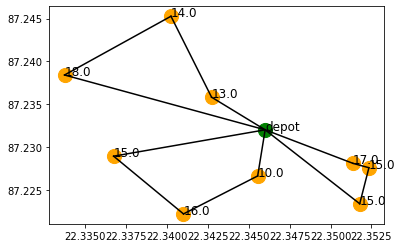

In [16]:
# visualization : plotting with matplolib
# plt.figure(figsize=(8,8))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()